In [1]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

from data_class import DataClass
from linear_noise_scheduler import LinearNoiseScheduler
from model import UNet

In [2]:
IMG_SIZE = 64
BATCH_SIZE = 4
NUM_IMAGES = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
output_dir = r'./outputs'

data_class = DataClass(BATCH_SIZE, IMG_SIZE, NUM_IMAGES)
dataloader = data_class.load_transformed_dataset()

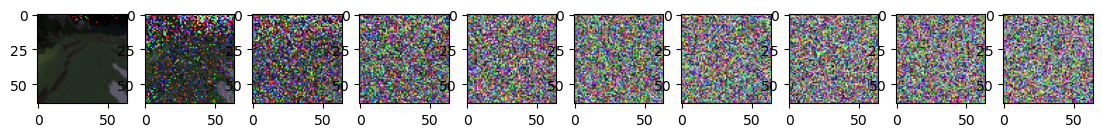

In [3]:
image = next(iter(dataloader))[0][0]
image = image.to(device)

plt.figure(figsize=(15, 15))
num_images = 10
T = 300 # timesteps
stepsize = int(T/num_images)
scheduler = LinearNoiseScheduler(timesteps=T, device=device)

for i in range(0, T, stepsize):
    t = torch.Tensor([i]).type(torch.int64)
    plt.subplot(1, num_images+1, int(i/stepsize) + 1)
    img, noise = scheduler.add_noise(image, t)
    data_class.show_tensor_image(img)

In [4]:
# sample n images from the model
def sample_images(model, n):
    model.eval()
    with torch.no_grad():
        x = torch.randn((n, 3, IMG_SIZE, IMG_SIZE)).to(device) # start with random noise
        for i in reversed(range(1, T)):
            t = (torch.ones(n).type(torch.int64) * i).to(device)
            predicted_noise = model(x, t)
            alphas_t = scheduler.alphas[t][:, None, None, None]
            alphas_cumprod_t = scheduler.alphas_cumprod[t][:, None, None, None]
            beta_t = scheduler.betas[t][:, None, None, None]
            if i > 1:
                noise = torch.rand_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alphas_t) *  (x - ((1.0 - alphas_t) / (torch.sqrt(1.0 - alphas_cumprod_t))) * predicted_noise) + torch.sqrt(beta_t) * noise
    model.train()
    return x

In [5]:
@torch.no_grad()
def show_image_timestep(model):
    img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE)).to(device)
    plt.figure(figsize=(15, 15))
    stepsize = int(T/num_images)
    
    for i in reversed(range(1, T)):
        t = torch.Tensor([i]).type(torch.int64).to(device)
        predicted_noise = model(img, t)
        alphas_t = scheduler.alphas[t][:, None, None, None]
        alphas_cumprod_t = scheduler.alphas_cumprod[t][:, None, None, None]
        beta_t = scheduler.betas[t][:, None, None, None]
        if i > 1:
            noise = torch.rand_like(img)
        else:
            noise = torch.zeros_like(img)
        img = 1 / torch.sqrt(alphas_t) *  (img - ((1.0 - alphas_t) / (torch.sqrt(1.0 - alphas_cumprod_t))) * predicted_noise) + torch.sqrt(beta_t) * noise
        
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize) + 1)
            data_class.show_tensor_image(img.detach().cpu())
    plt.show()

In [6]:
# Parameters
in_ch = 3
out_ch = 3
time_dim = 256
lr = 3e-4
n_epochs = 200

In [7]:
model = UNet(in_ch, out_ch, time_dim, device).to(device)
print(f"{sum(p.numel() for p in model.parameters()) / 10**6}M parameters")

23.332739M parameters


In [8]:
def train():
    losses = []
    mean_losses = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse = torch.nn.MSELoss()

    for epoch in range(n_epochs):
        epoch_loss = 0
        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)
            t = scheduler.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = scheduler.add_noise(images, t)
            predicted_noise = model(x_t, t)
            loss = mse(predicted_noise, noise)
            epoch_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        mean_epoch_loss = epoch_loss / len(dataloader)
        losses.append(mean_epoch_loss)
        mean_loss = torch.tensor(losses[-10:]).mean().item() # calculate mean loss over last 10 epochs
        mean_losses.append(mean_loss)
        
        # if epoch % 5 == 0:
        #     clear_output()
        #     plt.plot(losses, label='Loss')
        #     plt.plot(mean_losses, label='Mean Loss')
        #     plt.legend()
        #     plt.show()
            
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {mean_epoch_loss}")
            show_image_timestep(model)
        #   print(f"Epoch {epoch} | Loss: {loss.item()}")
        #   x = sample_images(model, images.shape[0])
        #   plt.figure(figsize=(10, 10))
        #   for i in range(x.shape[0]):
        #       plt.subplot(1, x.shape[0], i+1)
        #       filepath = os.path.join(output_dir, f'image_e{epoch}_s{i}.png')
        #       data_class.show_tensor_image(x[i], save=True, output_dir=filepath)

Epoch 0 | Loss: 0.8456361368298531


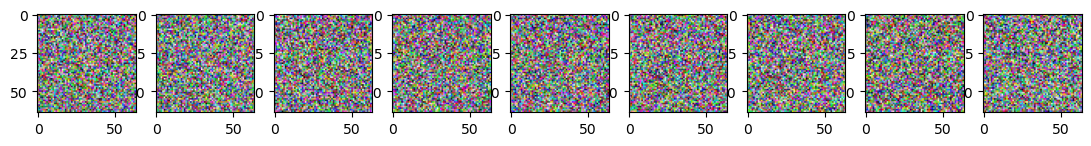

Epoch 10 | Loss: 0.1105933366343379


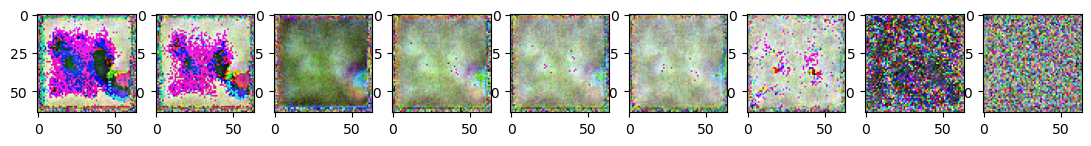

Epoch 20 | Loss: 0.11070101382210851


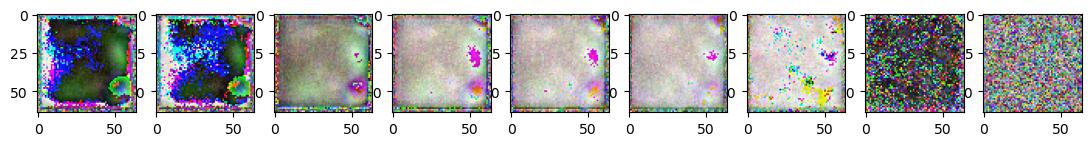

Epoch 30 | Loss: 0.049949359614402056


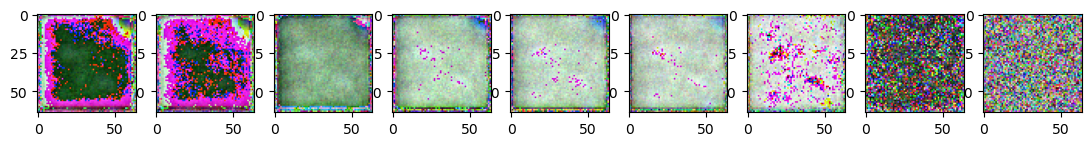

Epoch 40 | Loss: 0.049544299487024546


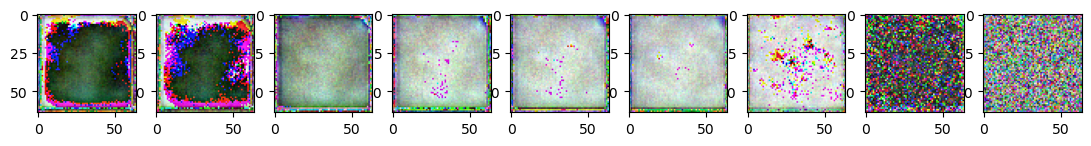

Epoch 50 | Loss: 0.05495792510919273


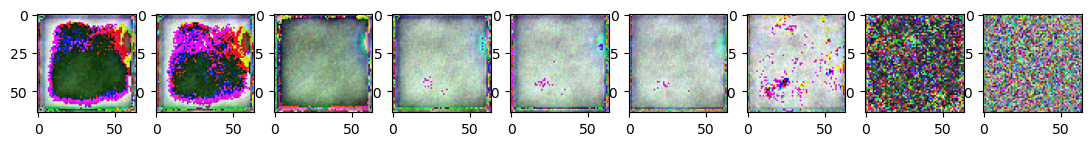

Epoch 60 | Loss: 0.05740766949020326


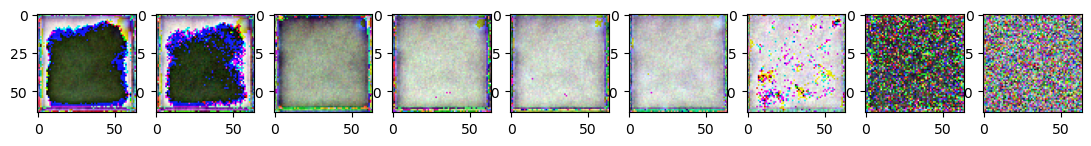

Epoch 70 | Loss: 0.07369710342027247


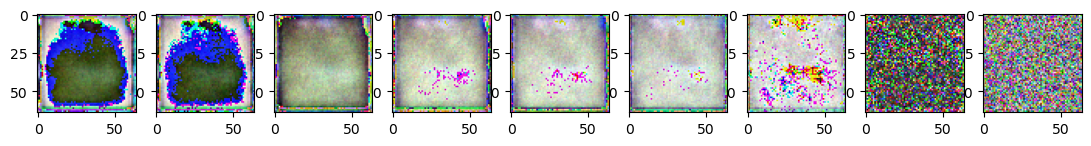

Epoch 80 | Loss: 0.03773850901052356


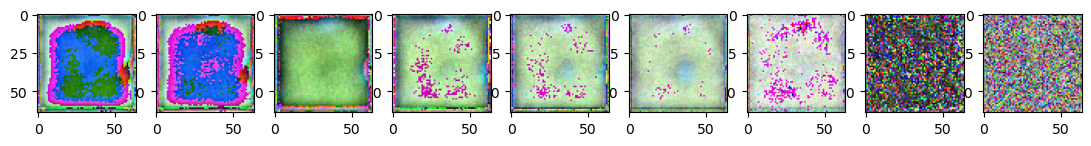

Epoch 90 | Loss: 0.07114043575711548


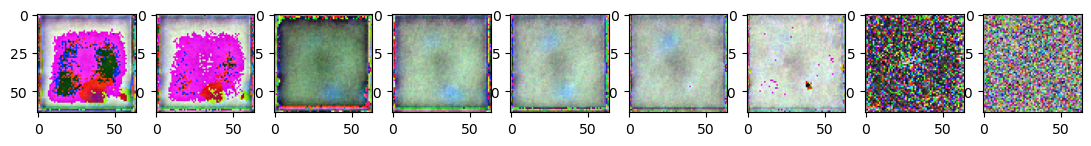

Epoch 100 | Loss: 0.035732956137508154


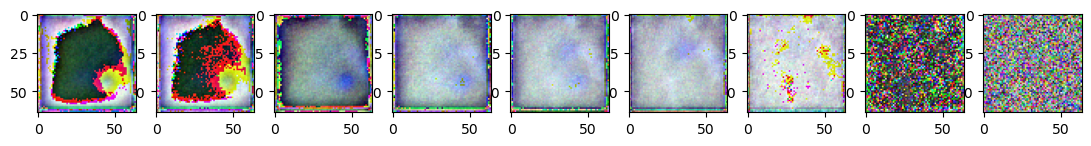

Epoch 110 | Loss: 0.08818772481754422


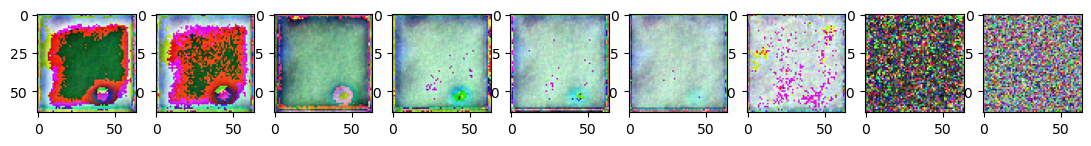

Epoch 120 | Loss: 0.06325308256782591


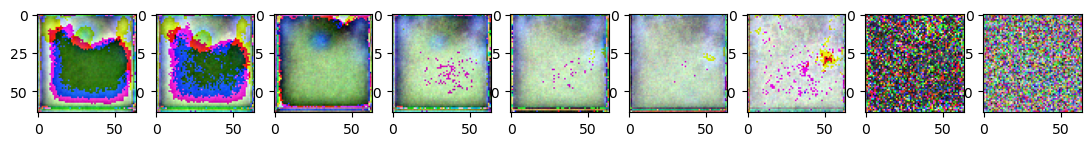

Epoch 130 | Loss: 0.0676181751769036


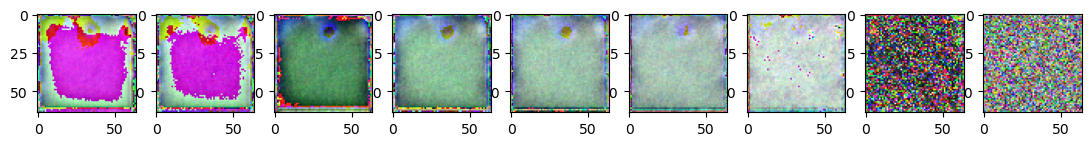

Epoch 140 | Loss: 0.02788292069453746


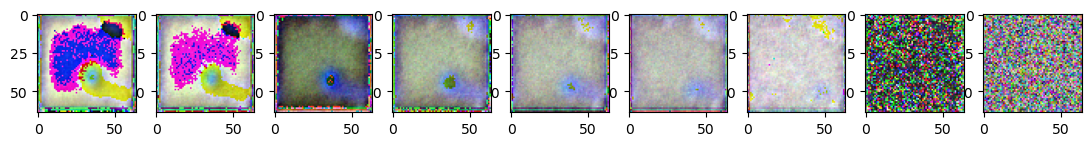

Epoch 150 | Loss: 0.03452322247903794


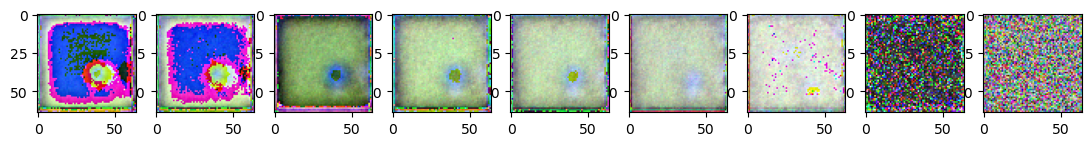

Epoch 160 | Loss: 0.024462103960104287


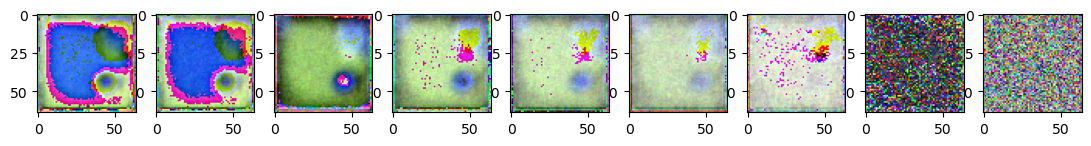

Epoch 170 | Loss: 0.05600708723068237


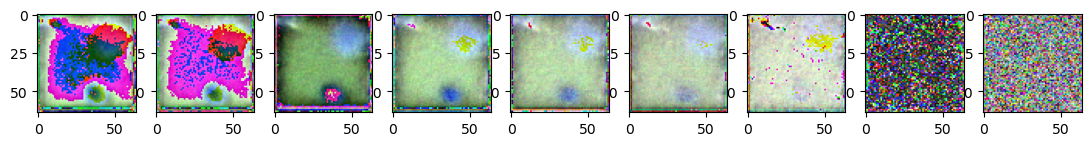

Epoch 180 | Loss: 0.0581578315468505


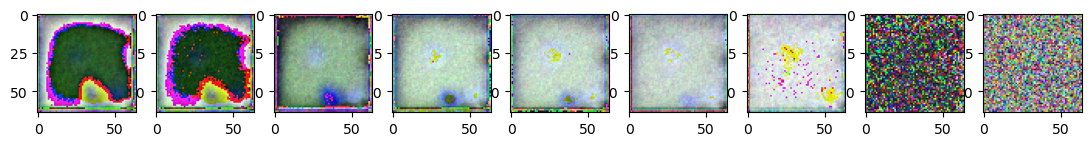

Epoch 190 | Loss: 0.021684443345293403


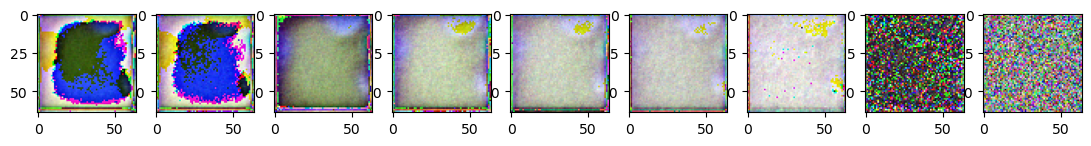

In [9]:
train()